In [13]:
%pylab inline
import gc
import matplotlib
import scipy
import fitsio

cmap=plt.get_cmap('tab20')

import hmf
import haloSim
import catSimutil as simutil
import astropy.table as astTable
cosmo   =   Cosmo(h=1.,omega_m=0.315)

from configparser import ConfigParser
from pixel3D import cartesianGrid3D

#figMsDir='/home/xiangchong/Documents/Docs/massMap/2-cluster_HSC_2021/'

Populating the interactive namespace from numpy and matplotlib


In [49]:
configName  =   'wrkDir/sim/planck-cosmo/config-pix48-nl10-pc.ini'
parser      =   ConfigParser()
parser.read(configName)
gridInfo    =   cartesianGrid3D(parser)
lensKer0=gridInfo.lensing_kernel(deltaIn=False)
lensKer1=gridInfo.lensing_kernel(deltaIn=True)
zbound=gridInfo.zlbound
zave=gridInfo.zlcgrid

parser2      =   ConfigParser()
parser2.read(configName)
parser2.set('sourceZ','zbound','[0.02,10]')
cg=cartesianGrid3D(parser2)
print(cg.xcgrid[24])

-1.6653345369377348e-16


In [60]:
# Initialize hmf
hmfmod='Tinker08'#'ST'#

pend='m146_152' 
#pend='m140_146'
mmin=eval(pend[1:].split('_')[0])/10.
mmax=eval(pend[1:].split('_')[1])/10.
mf = hmf.MassFunction(Mmin=mmin,Mmax=mmax,dlog10m=0.008,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)

mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
print(mf.cosmo)
print(mf.hmf_model)
# galaxy catalog for positions
infname='wrkDir/sim/HSC-obs/20200328/stampSim_HSClike_mask_shapenoise_photoz-202003282257.fits'
data=astTable.Table.read(infname)
print('number of loaded noise: %d' %len(data))
ng=len(data)//100
dataU=data[:ng]

FlatLambdaCDM(name="Planck15", H0=67.4 km / (Mpc s), Om0=0.315, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
<class 'hmf.mass_function.fitting_functions.Tinker08'>
number of loaded noise: 8257800


6.417472233748717 3.9583869872305626 525339924979996.4
3.9543447041377338 3.919263913657449 544455543594060.06
2.859202774354916 3.9081985172486737 521280824547230.94
2.309259560684204 3.8802987695281117 529252629374945.25
1.9320786640534386 3.8676153503723794 515657595992818.06
1.696574789319477 3.8427448831920215 522277253282504.5
1.5176567922078326 3.820406942422233 519202291708803.6
1.3814761370804982 3.80053456784984 519724697148722.44
1.267063541248389 3.786286035204493 513078828810053.94
1.1759646904803829 3.7713316254934774 508919315007135.06


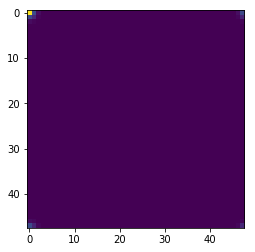

In [61]:
#Prepare basis vectors
ngrid=48
nn=500

outDir='wrkDir/sim/planck-cosmo/prior/'
haloAveAll=np.zeros((gridInfo.nzl,1,ngrid,ngrid))
for iz in range(0,gridInfo.nzl):
    z=zave[iz]
    pix2mpc=cosmo.Da(0.,z)*1./60./180*np.pi #[Mpc/h]
    mf.update(z=z)
    m = mf.m
    v=cosmo.V(zbound[iz],zbound[iz+1])*np.pi**2./180.**2./4./np.pi
    mass_func = mf.dndm*v
    imgList=np.empty((nn,ngrid,ngrid))
    rsAve=0.
    concAve=0.
    mAve=0.
    for i in range(nn):
        # randomly sampe a mass
        mi=simutil.mcSample(m,mass_func)[0]
        conc =  6.02*(mi/1.E13)**(-0.12)*(1.47/(1.+z))**(0.16)
        concAve+=conc
        rs_arcmin=haloSim.mc2rs(mi,conc,z)
        rsAve+=rs_arcmin
        mAve+=mi
    rsAve=rsAve/nn
    concAve=concAve/nn
    mAve=mAve/nn
    print(rsAve,concAve,mAve)
    #print(pix2mpc**2.)
    halo=haloSim.nfw_lensTJ03(mass=mAve,conc=concAve,redshift=z,ra=0.,dec=0.)
    SigmaArray  =   halo.Sigma(dataU['raR']*3600.,dataU['decR']*3600.)
    pixSigma=np.fft.ifftshift(cg.pixelize_data(dataU['raR'],dataU['decR'],None,SigmaArray)[0]/mAve)
    plt.imshow(pixSigma)
    haloAveAll[iz,0]=pixSigma
    del pixSigma,rsAve,concAve,mAve,halo,SigmaArray
    gc.collect()
pyfits.writeto(os.path.join(outDir,'haloBasis-nl10-pix48-%s.fits' %pend),haloAveAll,overwrite=True)

In [57]:
10**(14.74)

549540873857624.8

In [ ]:
        selfnorm2=np.sqrt(np.sum(imgList**2,axis=(1,2)))
        haloAve=np.average(imgList,axis=0)
        #norm=np.sqrt(np.sum(haloAve**2.))
        norm=np.sum(haloAve)*pix2mpc**2.
        # normalize to make sure \int dxdy f(x,y)=1
        haloAve=haloAve/norm
    mask=haloAveAll>1e-5
    haloAveAll[~mask]=0.
    print(np.min(haloAveAll))
    pyfits.writeto(os.path.join(outDir,'haloBasis-nl10.fits'),haloAveAll,overwrite=True)